In [1]:
import os, sys
sys.path.insert(1, '../')
from time import time
from importlib import reload

import numpy as np
import scipy as sc
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, QuantileRegressor
from tqdm import tqdm

import utils
import concentration as conc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
native_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
native_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


2.9325646632098326 4.9094161724139145 2.3799720197050194


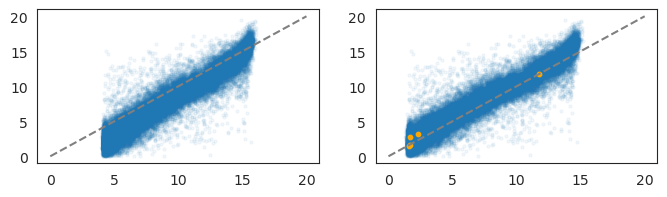

In [34]:
# see how many points needed to train to debias predictions
q = 0.25
n_train = 5
y_all = native_df.measured.to_numpy()
f_all = native_df.predicted.to_numpy()
# f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))

train_idx = np.random.choice(y_all.size, n_train, replace=False)
lm = QuantileRegressor(quantile=0.5, alpha=1e-4)
lm.fit(f_all[train_idx][:, None], y_all[train_idx])
pred_all = lm.predict(f_all[:, None])
print(np.quantile(y_all, q), np.quantile(f_all, q), np.quantile(pred_all, q))

fig, axs = plt.subplots(1, 2, figsize=(8, 2))
axs[0].scatter(f_all, y_all, s=5, alpha=0.05)
axs[0].plot([0, 20], [0, 20], linestyle='--', c='gray');
axs[1].scatter(pred_all, y_all, s=5, alpha=0.05)
axs[1].scatter(pred_all[train_idx], y_all[train_idx], c='orange', s=10)
axs[1].plot([0, 20], [0, 20], linestyle='--', c='gray');
plt.show()

In [10]:
reload(conc)
reload(utils)
n_trial = 500
qs = [0.5, 0.25, 0.75]
ns = np.logspace(np.log10(50), np.log10(1000), num=10, base=10).astype(int)
alpha = 0.1
delta = 0.09
theta_grid = np.arange(0, 20, 0.1)
c = 0.75
n_train = 0
save = True
save_fname = 'native-010423-delta{}.csv'.format(delta)

y_all = native_df.measured.to_numpy()
f_all = native_df.predicted.to_numpy()
f_all = 20 * (f_all - np.min(f_all)) / (np.max(f_all) - np.min(f_all))

columns = ['q', 'n', 'width', 'covered', 'estimator', 'lower', 'upper']
results = []
for q_idx, q in enumerate(qs):
    for n_idx, n in enumerate(ns):
        for _ in tqdm(range(n_trial)):
            
            ci_pp, ci_cl, cov_pp, cov_cl  = utils.trial(
                y_all, f_all, q, n, alpha, delta, theta_grid, c=c, n_train=n_train
            )
            results.append([q, n, ci_pp[1] - ci_pp[0], int(cov_pp), 'prediction-powered', ci_pp[0], ci_pp[1]])
            results.append([q, n, ci_cl[1] - ci_cl[0], int(cov_cl), 'classical', ci_cl[0], ci_cl[1]])
            
        df = pd.DataFrame(results, columns=columns)
        if save:
            df.to_csv(save_fname)
        
        print('n = {}, q = {}'.format(n, q))
        print('  avg. classical width: {:.2f}, avg. PP width: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].width.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].width.mean()
        ))
        print('  avg. classical cov: {:.2f}, avg. PP cov: {:.2f}'.format(
            df.loc[(df.estimator == 'classical') & (df.n == n) & (df.q == q)].covered.mean(),
            df.loc[(df.estimator == 'prediction-powered') & (df.n == n) & (df.q == q)].covered.mean()
        ))

100%|██████████| 500/500 [29:41<00:00,  3.56s/it]


n = 49, q = 0.5
  avg. classical width: 3.64, avg. PP width: 3.45
  avg. classical cov: 0.90, avg. PP cov: 1.00


100%|██████████| 500/500 [29:54<00:00,  3.59s/it]


n = 69, q = 0.5
  avg. classical width: 3.09, avg. PP width: 2.70
  avg. classical cov: 0.92, avg. PP cov: 1.00


100%|██████████| 500/500 [31:41<00:00,  3.80s/it]


n = 97, q = 0.5
  avg. classical width: 2.66, avg. PP width: 2.12
  avg. classical cov: 0.90, avg. PP cov: 0.99


100%|██████████| 500/500 [36:09<00:00,  4.34s/it]


n = 135, q = 0.5
  avg. classical width: 2.27, avg. PP width: 1.70
  avg. classical cov: 0.94, avg. PP cov: 0.98


100%|██████████| 500/500 [39:27<00:00,  4.74s/it]


n = 189, q = 0.5
  avg. classical width: 1.86, avg. PP width: 1.42
  avg. classical cov: 0.91, avg. PP cov: 0.99


100%|██████████| 500/500 [44:00<00:00,  5.28s/it]


n = 264, q = 0.5
  avg. classical width: 1.53, avg. PP width: 1.16
  avg. classical cov: 0.89, avg. PP cov: 0.97


100%|██████████| 500/500 [50:09<00:00,  6.02s/it]


n = 368, q = 0.5
  avg. classical width: 1.32, avg. PP width: 0.94
  avg. classical cov: 0.89, avg. PP cov: 0.98


100%|██████████| 500/500 [1:01:21<00:00,  7.36s/it]


n = 513, q = 0.5
  avg. classical width: 1.12, avg. PP width: 0.80
  avg. classical cov: 0.91, avg. PP cov: 0.98


100%|██████████| 500/500 [1:12:25<00:00,  8.69s/it]


n = 716, q = 0.5
  avg. classical width: 0.96, avg. PP width: 0.69
  avg. classical cov: 0.92, avg. PP cov: 0.97


  0%|          | 0/500 [00:00<?, ?it/s]../concentration.py:53: RuntimeWarning: overflow encountered in exp
  theta * np.exp(np.cumsum(np.log(1 + lambdaplus_n * (x_n - m)))),
100%|██████████| 500/500 [1:30:18<00:00, 10.84s/it]


n = 1000, q = 0.5
  avg. classical width: 0.81, avg. PP width: 0.58
  avg. classical cov: 0.91, avg. PP cov: 0.96


100%|██████████| 500/500 [28:29<00:00,  3.42s/it]


n = 49, q = 0.25
  avg. classical width: 1.79, avg. PP width: 2.13
  avg. classical cov: 0.93, avg. PP cov: 0.98


100%|██████████| 500/500 [29:26<00:00,  3.53s/it]


n = 69, q = 0.25
  avg. classical width: 1.45, avg. PP width: 1.67
  avg. classical cov: 0.91, avg. PP cov: 0.98


100%|██████████| 500/500 [31:12<00:00,  3.75s/it]


n = 97, q = 0.25
  avg. classical width: 1.17, avg. PP width: 1.33
  avg. classical cov: 0.93, avg. PP cov: 0.97


100%|██████████| 500/500 [36:53<00:00,  4.43s/it]


n = 135, q = 0.25
  avg. classical width: 0.97, avg. PP width: 1.08
  avg. classical cov: 0.90, avg. PP cov: 0.97


100%|██████████| 500/500 [40:44<00:00,  4.89s/it]


n = 189, q = 0.25
  avg. classical width: 0.81, avg. PP width: 0.88
  avg. classical cov: 0.90, avg. PP cov: 0.96


100%|██████████| 500/500 [45:48<00:00,  5.50s/it]


n = 264, q = 0.25
  avg. classical width: 0.67, avg. PP width: 0.69
  avg. classical cov: 0.89, avg. PP cov: 0.93


100%|██████████| 500/500 [52:23<00:00,  6.29s/it]


n = 368, q = 0.25
  avg. classical width: 0.56, avg. PP width: 0.58
  avg. classical cov: 0.89, avg. PP cov: 0.94


100%|██████████| 500/500 [1:03:20<00:00,  7.60s/it]


n = 513, q = 0.25
  avg. classical width: 0.47, avg. PP width: 0.48
  avg. classical cov: 0.89, avg. PP cov: 0.94


100%|██████████| 500/500 [1:15:20<00:00,  9.04s/it]


n = 716, q = 0.25
  avg. classical width: 0.40, avg. PP width: 0.40
  avg. classical cov: 0.90, avg. PP cov: 0.94


100%|██████████| 500/500 [1:33:20<00:00, 11.20s/it]


n = 1000, q = 0.25
  avg. classical width: 0.34, avg. PP width: 0.34
  avg. classical cov: 0.94, avg. PP cov: 0.93


100%|██████████| 500/500 [29:27<00:00,  3.54s/it]


n = 49, q = 0.75
  avg. classical width: 3.98, avg. PP width: 4.87
  avg. classical cov: 0.92, avg. PP cov: 1.00


100%|██████████| 500/500 [30:34<00:00,  3.67s/it]


n = 69, q = 0.75
  avg. classical width: 3.38, avg. PP width: 3.76
  avg. classical cov: 0.89, avg. PP cov: 1.00


100%|██████████| 500/500 [31:50<00:00,  3.82s/it]


n = 97, q = 0.75
  avg. classical width: 3.03, avg. PP width: 2.93
  avg. classical cov: 0.91, avg. PP cov: 0.99


100%|██████████| 500/500 [36:01<00:00,  4.32s/it]


n = 135, q = 0.75
  avg. classical width: 2.43, avg. PP width: 2.33
  avg. classical cov: 0.92, avg. PP cov: 0.97


100%|██████████| 500/500 [39:41<00:00,  4.76s/it]


n = 189, q = 0.75
  avg. classical width: 2.06, avg. PP width: 1.91
  avg. classical cov: 0.91, avg. PP cov: 0.98


100%|██████████| 500/500 [44:26<00:00,  5.33s/it]


n = 264, q = 0.75
  avg. classical width: 1.75, avg. PP width: 1.61
  avg. classical cov: 0.92, avg. PP cov: 0.97


100%|██████████| 500/500 [50:47<00:00,  6.09s/it]


n = 368, q = 0.75
  avg. classical width: 1.47, avg. PP width: 1.33
  avg. classical cov: 0.93, avg. PP cov: 0.98


100%|██████████| 500/500 [1:02:31<00:00,  7.50s/it]


n = 513, q = 0.75
  avg. classical width: 1.24, avg. PP width: 1.13
  avg. classical cov: 0.89, avg. PP cov: 0.97


100%|██████████| 500/500 [1:15:01<00:00,  9.00s/it]


n = 716, q = 0.75
  avg. classical width: 1.04, avg. PP width: 0.94
  avg. classical cov: 0.91, avg. PP cov: 0.97


100%|██████████| 500/500 [1:32:14<00:00, 11.07s/it]

n = 1000, q = 0.75
  avg. classical width: 0.88, avg. PP width: 0.81
  avg. classical cov: 0.90, avg. PP cov: 0.97
